In [1]:
import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 44100
blocksize = 11025
overlap = 5512

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../ESC-50/audio/'

In [5]:
path_to_db='../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']

In [7]:
mapping = {'dog': 0,'rooster': 0,'pig': 0,'cow': 0,'frog': 0,'cat': 0,'hen': 0,
            'insects': 0,'sheep': 0,'crow': 0,'rain': 1,'sea_waves': 1,'crackling_fire': 1,
            'crickets': 0,'chirping_birds': 0,'water_drops': 1,'wind': 1,'pouring_water': 1,
            'toilet_flush': 1,'thunderstorm': 1,'crying_baby': 0,'sneezing': 0,'clapping': 0,
            'breathing': 0,'coughing': 0,'footsteps': 1,'laughing': 0,'brushing_teeth': 1,
            'snoring': 0,'drinking_sipping': 1,'door_wood_knock': 1,'mouse_click': 1,
            'keyboard_typing': 1,'door_wood_creaks': 1,'can_opening': 1,'washing_machine': 1,
            'vacuum_cleaner': 1,'clock_alarm': 1,'clock_tick': 1,'glass_breaking':1,'helicopter': 1,
            'chainsaw': 1,'siren': 1,'car_horn': 1,'engine': 1,'train': 1,'church_bells': 1,
            'airplane': 1,'fireworks': 1,'hand_saw': 1,
            }

In [8]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [10]:
df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        fld=range(2,6), 
                        blocksize=blocksize, 
                        overlap=overlap)

In [11]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,106,107,108,109,110,111,112,113,l_target,h_target
count,56774.000000,56774.000000,56774.000000,56774.000000,56774.000000,56774.000000,56774.000000,56774.000000,56774.000000,56774.000000,...,56774.000000,56774.000000,56774.000000,56774.000000,56774.000000,56774.000000,56774.000000,56774.000000,56774.000000,56774.000000
mean,0.285285,0.256802,0.206894,0.190015,0.177811,0.171185,0.163145,0.161376,0.156221,0.153856,...,-0.000479,0.000363,-0.000405,0.000244,-0.000378,0.000146,-0.000278,0.000103,0.628281,24.582080
std,0.120389,0.113905,0.075690,0.068402,0.064552,0.062244,0.059996,0.059689,0.058341,0.057803,...,0.002774,0.002760,0.002738,0.002748,0.002741,0.002752,0.002730,0.002734,0.483268,14.541264
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.105382,-0.096944,-0.096944,-0.105382,-0.096944,-0.105382,-0.096944,-0.105382,0.000000,0.000000
25%,0.205942,0.180653,0.159912,0.147143,0.136940,0.131640,0.125051,0.123635,0.118691,0.116852,...,-0.001145,-0.000277,-0.001026,-0.000363,-0.000950,-0.000426,-0.000841,-0.000460,0.000000,12.000000
50%,0.279116,0.246014,0.209417,0.193233,0.180370,0.173561,0.164783,0.163507,0.157868,0.155331,...,-0.000477,0.000354,-0.000374,0.000246,-0.000304,0.000150,-0.000199,0.000107,1.000000,24.000000
75%,0.360475,0.318048,0.255099,0.234678,0.220754,0.212805,0.203306,0.201579,0.195289,0.192444,...,0.000166,0.001028,0.000240,0.000906,0.000281,0.000787,0.000364,0.000726,1.000000,37.000000
max,0.874875,0.844750,0.632411,0.568259,0.706872,0.593027,0.555086,0.475656,0.469702,0.530927,...,0.096944,0.105382,0.105382,0.096944,0.105382,0.096944,0.105382,0.088065,1.000000,49.000000


In [12]:
a_data = df[df['l_target'] == 0]
i_data = df[df['l_target'] == 1]

# Animal Sounds

In [13]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(a_data, test_size=0.20, random_state=56)

In [14]:
train_X = train.drop(['l_target', 'h_target'], axis=1)
train_y = train['h_target']
test_X = test.drop(['l_target', 'h_target'], axis=1)
test_y = test['h_target']

In [15]:
from keras.layers import Dense, Dropout
from keras.models import Sequential

def gpu_mfcc_deep_net_a():
    # Create Model
    model = Sequential()
    model.add(Dense(100, activation='relu', input_shape=(114,)))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))    
    model.add(Dense(19, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    model.summary()

    
    return model

In [16]:
train_y.describe()

count    16883.000000
mean        12.333768
std          9.082668
min          0.000000
25%          4.000000
50%          9.000000
75%         22.000000
max         28.000000
Name: h_target, dtype: float64

In [17]:
anim = KerasClassifier(build_fn=gpu_mfcc_deep_net_a, 
                       epochs=500, 
                       batch_size=128, 
                       validation_split=0.15)
history = anim.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               11500     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                6464      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
__________

Epoch 44/500
14350/14350 [==============================] - 1s 54us/step - loss: 2.1004 - acc: 0.3205 - val_loss: 2.2615 - val_acc: 0.3004
Epoch 45/500
14350/14350 [==============================] - 1s 55us/step - loss: 2.0994 - acc: 0.3274 - val_loss: 2.2664 - val_acc: 0.3087
Epoch 46/500
14350/14350 [==============================] - 1s 54us/step - loss: 2.0932 - acc: 0.3242 - val_loss: 2.2379 - val_acc: 0.3020
Epoch 47/500
14350/14350 [==============================] - 1s 55us/step - loss: 2.0771 - acc: 0.3336 - val_loss: 2.2968 - val_acc: 0.3123
Epoch 48/500
14350/14350 [==============================] - 1s 54us/step - loss: 2.0663 - acc: 0.3355 - val_loss: 2.2537 - val_acc: 0.3036
Epoch 49/500
14350/14350 [==============================] - 1s 54us/step - loss: 2.0668 - acc: 0.3293 - val_loss: 2.2640 - val_acc: 0.3123
Epoch 50/500
14350/14350 [==============================] - 1s 54us/step - loss: 2.0443 - acc: 0.3441 - val_loss: 2.2464 - val_acc: 0.3131
Epoch 51/500
14350/14350 [=

Epoch 103/500
14350/14350 [==============================] - 1s 54us/step - loss: 1.8040 - acc: 0.4194 - val_loss: 2.1843 - val_acc: 0.3518
Epoch 104/500
14350/14350 [==============================] - 1s 55us/step - loss: 1.8132 - acc: 0.4162 - val_loss: 2.2141 - val_acc: 0.3431
Epoch 105/500
14350/14350 [==============================] - 1s 53us/step - loss: 1.8114 - acc: 0.4208 - val_loss: 2.2033 - val_acc: 0.3502
Epoch 106/500
14350/14350 [==============================] - 1s 54us/step - loss: 1.8057 - acc: 0.4164 - val_loss: 2.2590 - val_acc: 0.3470
Epoch 107/500
14350/14350 [==============================] - 1s 55us/step - loss: 1.8158 - acc: 0.4143 - val_loss: 2.2257 - val_acc: 0.3415
Epoch 108/500
14350/14350 [==============================] - 1s 55us/step - loss: 1.8856 - acc: 0.4000 - val_loss: 2.2112 - val_acc: 0.3300
Epoch 109/500
14350/14350 [==============================] - 1s 54us/step - loss: 1.8023 - acc: 0.4217 - val_loss: 2.2106 - val_acc: 0.3407
Epoch 110/500
14350/

14350/14350 [==============================] - 1s 54us/step - loss: 1.6939 - acc: 0.4577 - val_loss: 2.1631 - val_acc: 0.3794
Epoch 162/500
14350/14350 [==============================] - 1s 51us/step - loss: 1.6539 - acc: 0.4678 - val_loss: 2.1732 - val_acc: 0.3691
Epoch 163/500
14350/14350 [==============================] - 1s 63us/step - loss: 1.6701 - acc: 0.4689 - val_loss: 2.1667 - val_acc: 0.3703
Epoch 164/500
14350/14350 [==============================] - 1s 63us/step - loss: 1.6770 - acc: 0.4603 - val_loss: 2.2083 - val_acc: 0.3691
Epoch 165/500
14350/14350 [==============================] - 1s 50us/step - loss: 1.6671 - acc: 0.4655 - val_loss: 2.1596 - val_acc: 0.3644
Epoch 166/500
14350/14350 [==============================] - 1s 49us/step - loss: 1.6689 - acc: 0.4662 - val_loss: 2.1870 - val_acc: 0.3707
Epoch 167/500
14350/14350 [==============================] - 1s 60us/step - loss: 1.6619 - acc: 0.4709 - val_loss: 2.1690 - val_acc: 0.3707
Epoch 168/500
14350/14350 [=======

14350/14350 [==============================] - 1s 54us/step - loss: 1.6006 - acc: 0.4897 - val_loss: 2.1655 - val_acc: 0.3833
Epoch 220/500
14350/14350 [==============================] - 1s 53us/step - loss: 1.5887 - acc: 0.4899 - val_loss: 2.1356 - val_acc: 0.3924
Epoch 221/500
14350/14350 [==============================] - 1s 55us/step - loss: 1.5818 - acc: 0.4921 - val_loss: 2.1395 - val_acc: 0.3964
Epoch 222/500
14350/14350 [==============================] - 1s 54us/step - loss: 1.5771 - acc: 0.4954 - val_loss: 2.1530 - val_acc: 0.3897
Epoch 223/500
14350/14350 [==============================] - 1s 53us/step - loss: 1.5884 - acc: 0.4923 - val_loss: 2.1401 - val_acc: 0.3861
Epoch 224/500
14350/14350 [==============================] - 1s 55us/step - loss: 1.5741 - acc: 0.4974 - val_loss: 2.1588 - val_acc: 0.3873
Epoch 225/500
14350/14350 [==============================] - 1s 54us/step - loss: 1.5680 - acc: 0.5013 - val_loss: 2.1392 - val_acc: 0.3940
Epoch 226/500
14350/14350 [=======

14350/14350 [==============================] - 1s 58us/step - loss: 1.4912 - acc: 0.5276 - val_loss: 2.1101 - val_acc: 0.3968
Epoch 278/500
14350/14350 [==============================] - 1s 65us/step - loss: 1.4832 - acc: 0.5229 - val_loss: 2.1632 - val_acc: 0.4019
Epoch 279/500
14350/14350 [==============================] - 1s 71us/step - loss: 1.5053 - acc: 0.5182 - val_loss: 2.1565 - val_acc: 0.4070
Epoch 280/500
14350/14350 [==============================] - 1s 56us/step - loss: 1.4850 - acc: 0.5254 - val_loss: 2.1890 - val_acc: 0.4023
Epoch 281/500
14350/14350 [==============================] - 1s 46us/step - loss: 1.5128 - acc: 0.5193 - val_loss: 2.1569 - val_acc: 0.3944
Epoch 282/500
14350/14350 [==============================] - 1s 43us/step - loss: 1.5259 - acc: 0.5193 - val_loss: 2.1653 - val_acc: 0.3972
Epoch 283/500
14350/14350 [==============================] - 1s 45us/step - loss: 1.5160 - acc: 0.5182 - val_loss: 2.1369 - val_acc: 0.4047
Epoch 284/500
14350/14350 [=======

14350/14350 [==============================] - 1s 53us/step - loss: 1.4633 - acc: 0.5367 - val_loss: 2.1317 - val_acc: 0.4173
Epoch 336/500
14350/14350 [==============================] - 1s 54us/step - loss: 1.4831 - acc: 0.5292 - val_loss: 2.1863 - val_acc: 0.3983
Epoch 337/500
14350/14350 [==============================] - 1s 53us/step - loss: 1.4440 - acc: 0.5443 - val_loss: 2.1778 - val_acc: 0.4118
Epoch 338/500
14350/14350 [==============================] - 1s 54us/step - loss: 1.4747 - acc: 0.5293 - val_loss: 2.1604 - val_acc: 0.4129
Epoch 339/500
14350/14350 [==============================] - 1s 55us/step - loss: 1.4571 - acc: 0.5352 - val_loss: 2.1367 - val_acc: 0.4129
Epoch 340/500
14350/14350 [==============================] - 1s 56us/step - loss: 1.4474 - acc: 0.5446 - val_loss: 2.1424 - val_acc: 0.4122
Epoch 341/500
14350/14350 [==============================] - 1s 52us/step - loss: 1.4374 - acc: 0.5431 - val_loss: 2.1353 - val_acc: 0.4193
Epoch 342/500
14350/14350 [=======

14350/14350 [==============================] - 1s 56us/step - loss: 1.3973 - acc: 0.5603 - val_loss: 2.2042 - val_acc: 0.4205
Epoch 394/500
14350/14350 [==============================] - 1s 55us/step - loss: 1.4315 - acc: 0.5478 - val_loss: 2.1433 - val_acc: 0.4240
Epoch 395/500
14350/14350 [==============================] - 1s 53us/step - loss: 1.3942 - acc: 0.5591 - val_loss: 2.1261 - val_acc: 0.4220
Epoch 396/500
14350/14350 [==============================] - 1s 54us/step - loss: 1.3932 - acc: 0.5624 - val_loss: 2.1314 - val_acc: 0.4212
Epoch 397/500
14350/14350 [==============================] - 1s 54us/step - loss: 1.4226 - acc: 0.5515 - val_loss: 2.1446 - val_acc: 0.4145
Epoch 398/500
14350/14350 [==============================] - 1s 54us/step - loss: 1.3977 - acc: 0.5519 - val_loss: 2.1356 - val_acc: 0.4220
Epoch 399/500
14350/14350 [==============================] - 1s 54us/step - loss: 1.3954 - acc: 0.5552 - val_loss: 2.1426 - val_acc: 0.4347
Epoch 400/500
14350/14350 [=======

14350/14350 [==============================] - 1s 57us/step - loss: 1.3796 - acc: 0.5672 - val_loss: 2.1111 - val_acc: 0.4315
Epoch 452/500
14350/14350 [==============================] - 1s 55us/step - loss: 1.3676 - acc: 0.5737 - val_loss: 2.1518 - val_acc: 0.4311
Epoch 453/500
14350/14350 [==============================] - 1s 59us/step - loss: 1.3751 - acc: 0.5652 - val_loss: 2.1382 - val_acc: 0.4276
Epoch 454/500
14350/14350 [==============================] - 1s 58us/step - loss: 1.3863 - acc: 0.5597 - val_loss: 2.1520 - val_acc: 0.4291
Epoch 455/500
14350/14350 [==============================] - 1s 58us/step - loss: 1.3667 - acc: 0.5718 - val_loss: 2.1542 - val_acc: 0.4394
Epoch 456/500
14350/14350 [==============================] - 1s 56us/step - loss: 1.3664 - acc: 0.5717 - val_loss: 2.1515 - val_acc: 0.4390
Epoch 457/500
14350/14350 [==============================] - 1s 58us/step - loss: 1.3654 - acc: 0.5725 - val_loss: 2.1626 - val_acc: 0.4386
Epoch 458/500
14350/14350 [=======

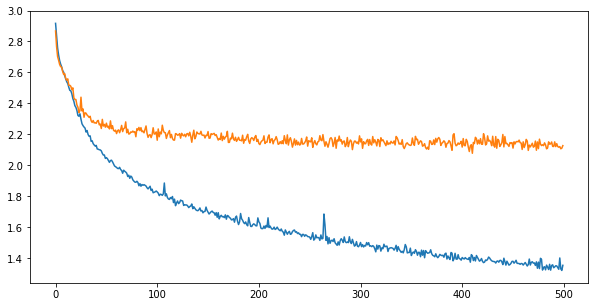

In [18]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

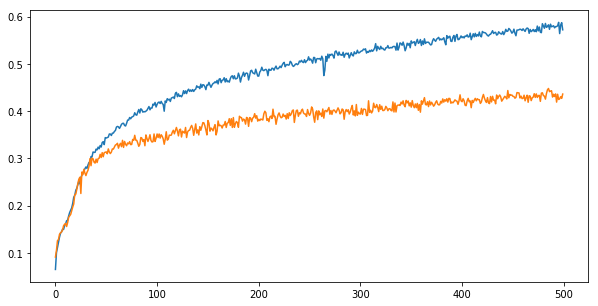

In [ ]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.4352049277422412
Confusion matrix, without normalization
[[ 68  16  16   6   1   7   8   1   4   0   0   0   2  43   1   2  12  13
    5]
 [  6  90   1   7   1  22   1   1   3   1   1   2   6  36   0   2   1   5
    1]
 [  2   0  83   5   6   9   5   8   4   1   3   1   3  11  14  27   3   5
   14]
 [  2   3  29  78  11   7   0  12  20   6   1   2   2  19   3  18   2   3
   12]
 [  3   2  22   6 141   8   1   3   5   1   0   0   3   2   3   3   4  17
    3]
 [  4  16  14   3   8  72   3   0   6   4   1   0  20  22   1  16   6  11
    7]
 [ 10   1  57  11   9   5  70  12   4   1   1   2  11   6   5   8  10  30
    3]
 [  0   1  44   6   1   0   2 139   3   1   5   4   0   3   4  13   0   3
   14]
 [  1   3  21  47  13  12   2  10  66  15   2   6   6   6   4  20   0   5
   13]
 [  0   1   4  15   3   9   0   4  42 113   0  10   6   2   2  24   1   2
    3]
 [  0   0   3   1   0   0   0  27   0   0 186   7   0   1   3   1   0   0
    9]
 [  1   2   8   6   0   4   0  17   5   8   6 157 

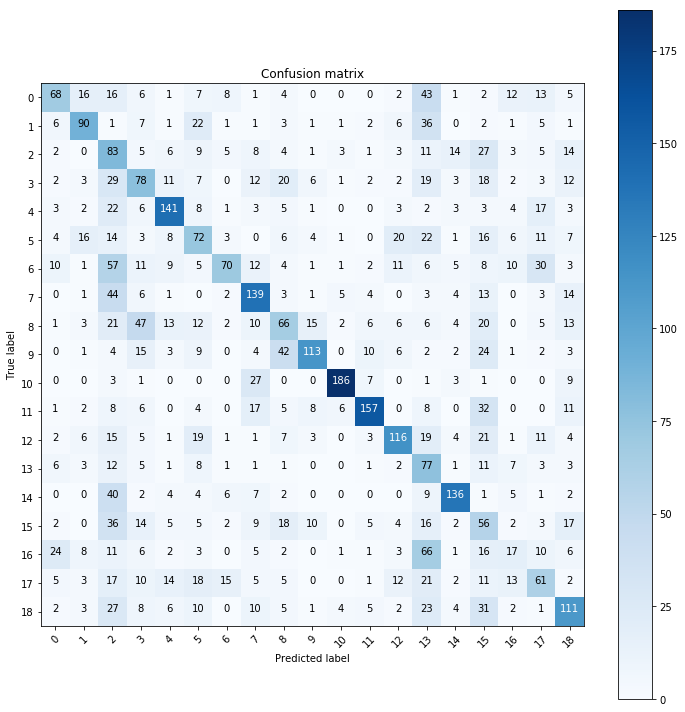

In [ ]:
pred = anim.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, range(0,19))
plt.show()

# Interacting Materials

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(i_data, test_size=0.20, random_state=56)

In [ ]:
train_X = train.drop(['l_target', 'h_target'], axis=1)
train_y = train['h_target']
test_X = test.drop(['l_target', 'h_target'], axis=1)
test_y = test['h_target']

In [ ]:
def gpu_mfcc_deep_net_i():
    # Create Model
    model = Sequential()
    model.add(Dense(100, activation='relu', input_shape=(114,)))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(31, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    model.summary()

    
    return model

In [ ]:
inter = KerasClassifier(build_fn=gpu_mfcc_deep_net_i, epochs=500, batch_size=128, validation_split=0.15)
history = inter.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 100)               11500     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                6464      
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
__________

Epoch 48/500
24255/24255 [==============================] - 1s 48us/step - loss: 2.1402 - acc: 0.3584 - val_loss: 2.0875 - val_acc: 0.3756
Epoch 49/500
24255/24255 [==============================] - 1s 47us/step - loss: 2.1190 - acc: 0.3616 - val_loss: 2.0648 - val_acc: 0.3875
Epoch 50/500
24255/24255 [==============================] - 1s 48us/step - loss: 2.1297 - acc: 0.3559 - val_loss: 2.0655 - val_acc: 0.3859
Epoch 51/500
24255/24255 [==============================] - 1s 48us/step - loss: 2.1192 - acc: 0.3570 - val_loss: 2.0648 - val_acc: 0.3845
Epoch 52/500
24255/24255 [==============================] - 1s 50us/step - loss: 2.1158 - acc: 0.3593 - val_loss: 2.0700 - val_acc: 0.3822
Epoch 53/500
24255/24255 [==============================] - 1s 47us/step - loss: 2.1126 - acc: 0.3642 - val_loss: 2.0433 - val_acc: 0.3934
Epoch 54/500
24255/24255 [==============================] - 1s 47us/step - loss: 2.1108 - acc: 0.3682 - val_loss: 2.0575 - val_acc: 0.3873
Epoch 55/500
24255/24255 [=

Epoch 107/500
24255/24255 [==============================] - 1s 48us/step - loss: 1.9411 - acc: 0.4129 - val_loss: 1.9068 - val_acc: 0.4384
Epoch 108/500
24255/24255 [==============================] - 1s 49us/step - loss: 1.9436 - acc: 0.4148 - val_loss: 1.8953 - val_acc: 0.4415
Epoch 109/500
24255/24255 [==============================] - 1s 48us/step - loss: 1.9326 - acc: 0.4177 - val_loss: 1.8984 - val_acc: 0.4335
Epoch 110/500
24255/24255 [==============================] - 1s 49us/step - loss: 1.9397 - acc: 0.4183 - val_loss: 1.9107 - val_acc: 0.4335
Epoch 111/500
24255/24255 [==============================] - 1s 48us/step - loss: 1.9429 - acc: 0.4159 - val_loss: 1.9116 - val_acc: 0.4331
Epoch 112/500
24255/24255 [==============================] - 1s 48us/step - loss: 1.9286 - acc: 0.4188 - val_loss: 1.8946 - val_acc: 0.4324
Epoch 113/500
24255/24255 [==============================] - 1s 48us/step - loss: 1.9295 - acc: 0.4214 - val_loss: 1.8884 - val_acc: 0.4384
Epoch 114/500
24255/

24255/24255 [==============================] - 1s 47us/step - loss: 1.8545 - acc: 0.4444 - val_loss: 1.8352 - val_acc: 0.4518
Epoch 166/500
24255/24255 [==============================] - 1s 48us/step - loss: 1.8650 - acc: 0.4386 - val_loss: 1.8505 - val_acc: 0.4520
Epoch 167/500
24255/24255 [==============================] - 1s 47us/step - loss: 1.8514 - acc: 0.4417 - val_loss: 1.8394 - val_acc: 0.4548
Epoch 168/500
24255/24255 [==============================] - 1s 47us/step - loss: 1.8500 - acc: 0.4443 - val_loss: 1.8404 - val_acc: 0.4562
Epoch 169/500
24255/24255 [==============================] - 1s 48us/step - loss: 1.8682 - acc: 0.4372 - val_loss: 1.8446 - val_acc: 0.4550
Epoch 170/500
24255/24255 [==============================] - 1s 48us/step - loss: 1.8582 - acc: 0.4423 - val_loss: 1.8416 - val_acc: 0.4501
Epoch 171/500
24255/24255 [==============================] - 1s 48us/step - loss: 1.8600 - acc: 0.4419 - val_loss: 1.8366 - val_acc: 0.4522
Epoch 172/500
24255/24255 [=======

24255/24255 [==============================] - 1s 47us/step - loss: 1.8194 - acc: 0.4531 - val_loss: 1.8073 - val_acc: 0.4648
Epoch 224/500
24255/24255 [==============================] - 1s 47us/step - loss: 1.8062 - acc: 0.4590 - val_loss: 1.8258 - val_acc: 0.4686
Epoch 225/500
24255/24255 [==============================] - 1s 48us/step - loss: 1.8070 - acc: 0.4609 - val_loss: 1.8055 - val_acc: 0.4681
Epoch 226/500
24255/24255 [==============================] - 1s 49us/step - loss: 1.7987 - acc: 0.4590 - val_loss: 1.8260 - val_acc: 0.4574
Epoch 227/500
24255/24255 [==============================] - 1s 48us/step - loss: 1.8059 - acc: 0.4590 - val_loss: 1.8148 - val_acc: 0.4662
Epoch 228/500
24255/24255 [==============================] - 1s 47us/step - loss: 1.8123 - acc: 0.4545 - val_loss: 1.8182 - val_acc: 0.4634
Epoch 229/500
24255/24255 [==============================] - 1s 48us/step - loss: 1.8014 - acc: 0.4588 - val_loss: 1.8093 - val_acc: 0.4740
Epoch 230/500
24255/24255 [=======

24255/24255 [==============================] - 1s 43us/step - loss: 1.7778 - acc: 0.4679 - val_loss: 1.8027 - val_acc: 0.4775
Epoch 282/500
24255/24255 [==============================] - 1s 42us/step - loss: 1.7880 - acc: 0.4604 - val_loss: 1.8063 - val_acc: 0.4719
Epoch 283/500
24255/24255 [==============================] - 1s 41us/step - loss: 1.7897 - acc: 0.4616 - val_loss: 1.7985 - val_acc: 0.4728
Epoch 284/500
24255/24255 [==============================] - 1s 40us/step - loss: 1.7738 - acc: 0.4704 - val_loss: 1.8013 - val_acc: 0.4770
Epoch 285/500
24255/24255 [==============================] - 1s 40us/step - loss: 1.7819 - acc: 0.4645 - val_loss: 1.7942 - val_acc: 0.4768
Epoch 286/500
24255/24255 [==============================] - 1s 42us/step - loss: 1.7782 - acc: 0.4672 - val_loss: 1.7942 - val_acc: 0.4765
Epoch 287/500
24255/24255 [==============================] - 1s 36us/step - loss: 1.7801 - acc: 0.4673 - val_loss: 1.8252 - val_acc: 0.4660
Epoch 288/500
24255/24255 [=======

24255/24255 [==============================] - 1s 47us/step - loss: 1.7524 - acc: 0.4748 - val_loss: 1.7809 - val_acc: 0.4782
Epoch 340/500
24255/24255 [==============================] - 1s 48us/step - loss: 1.7568 - acc: 0.4763 - val_loss: 1.7840 - val_acc: 0.4789
Epoch 341/500
24255/24255 [==============================] - 1s 47us/step - loss: 1.7480 - acc: 0.4754 - val_loss: 1.7843 - val_acc: 0.4831
Epoch 342/500
24255/24255 [==============================] - 1s 46us/step - loss: 1.7536 - acc: 0.4733 - val_loss: 1.7841 - val_acc: 0.4751
Epoch 343/500
24255/24255 [==============================] - 1s 47us/step - loss: 1.7646 - acc: 0.4710 - val_loss: 1.7838 - val_acc: 0.4735
Epoch 344/500
24255/24255 [==============================] - 1s 54us/step - loss: 1.7574 - acc: 0.4706 - val_loss: 1.7910 - val_acc: 0.4758
Epoch 345/500
24255/24255 [==============================] - 1s 52us/step - loss: 1.7541 - acc: 0.4732 - val_loss: 1.7773 - val_acc: 0.4805
Epoch 346/500
24255/24255 [=======

24255/24255 [==============================] - 1s 47us/step - loss: 1.7372 - acc: 0.4805 - val_loss: 1.7742 - val_acc: 0.4777
Epoch 398/500
24255/24255 [==============================] - 1s 47us/step - loss: 1.7334 - acc: 0.4805 - val_loss: 1.7708 - val_acc: 0.4868
Epoch 399/500
24255/24255 [==============================] - 1s 46us/step - loss: 1.7348 - acc: 0.4789 - val_loss: 1.7833 - val_acc: 0.4852
Epoch 400/500
24255/24255 [==============================] - 1s 47us/step - loss: 1.7359 - acc: 0.4810 - val_loss: 1.7861 - val_acc: 0.4749
Epoch 401/500
24255/24255 [==============================] - 1s 46us/step - loss: 1.7416 - acc: 0.4747 - val_loss: 1.7652 - val_acc: 0.4859
Epoch 402/500
24255/24255 [==============================] - 1s 46us/step - loss: 1.7266 - acc: 0.4806 - val_loss: 1.7817 - val_acc: 0.4716
Epoch 403/500
24255/24255 [==============================] - 1s 48us/step - loss: 1.7316 - acc: 0.4800 - val_loss: 1.7896 - val_acc: 0.4723
Epoch 404/500
24255/24255 [=======

24255/24255 [==============================] - 1s 46us/step - loss: 1.7191 - acc: 0.4867 - val_loss: 1.7683 - val_acc: 0.4803
Epoch 456/500
24255/24255 [==============================] - 1s 47us/step - loss: 1.7220 - acc: 0.4846 - val_loss: 1.7680 - val_acc: 0.4817
Epoch 457/500
24255/24255 [==============================] - 1s 47us/step - loss: 1.7198 - acc: 0.4860 - val_loss: 1.7657 - val_acc: 0.4805
Epoch 458/500
24255/24255 [==============================] - 1s 46us/step - loss: 1.7124 - acc: 0.4867 - val_loss: 1.7653 - val_acc: 0.4868
Epoch 459/500
24255/24255 [==============================] - 1s 47us/step - loss: 1.7266 - acc: 0.4797 - val_loss: 1.7690 - val_acc: 0.4798
Epoch 460/500
24255/24255 [==============================] - 1s 48us/step - loss: 1.7109 - acc: 0.4867 - val_loss: 1.7650 - val_acc: 0.4835
Epoch 461/500
24255/24255 [==============================] - 1s 47us/step - loss: 1.7178 - acc: 0.4862 - val_loss: 1.7693 - val_acc: 0.4835
Epoch 462/500
24255/24255 [=======

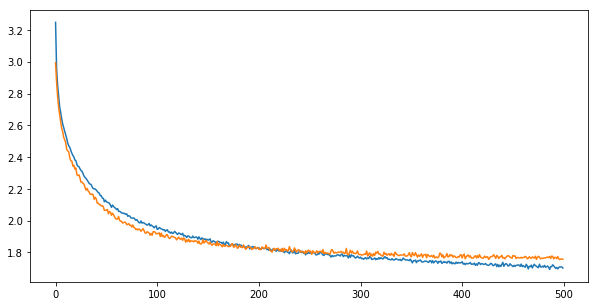

In [ ]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

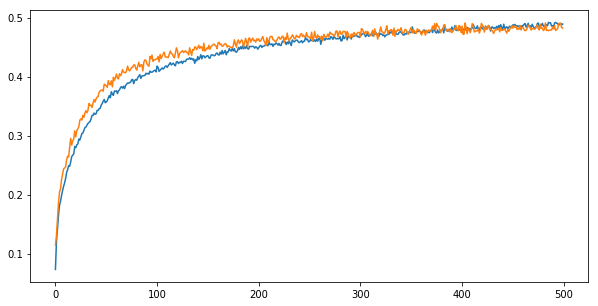

In [ ]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.4964956546117185
Confusion matrix, without normalization
[[133  17  12   0   0   2  11   0   7   1   0   0   2   1   0   0   6  15
    0   0   0   0   3   0   0  14   8   0   0   0   1]
 [ 48 111   1   1   3   0  11   0   3   0   0   1   0   0   2   1  13  26
    0   0   0   4  25   0   3   1  25   2   2   0   1]
 [  8   2 162   3   0  16   7   0   8   0   0   1   1   9   0   2   3   1
    2   3   1   2   0   0   0   5   0   1   1   1   1]
 [  0   1   8  69   6  15   3   1   7  14   7  19   3   5   0  16   3   0
    1   9   4   0   0   0   0   0   1   5   0   8   1]
 [  3   7   3   4 188   0   0   5   0   0   0   0   1   0   0   0  13   3
    0   1   0   5   0   3   1   3  13   3  16   0   0]
 [  0   0  19  13   0 140  14   2   3  11   3   5   4   6   4   4   0   0
    4   0   1   0   0   2   0   3   0   0   0   2   1]
 [ 15   4   7   7   1  14  98   2  10   6   3   5   2   0   1   7   7  10
    0   2   4   0   4   2   0   1  11   1   0   2   5]
 [  1   1   2   5   8   3   0 132   1 

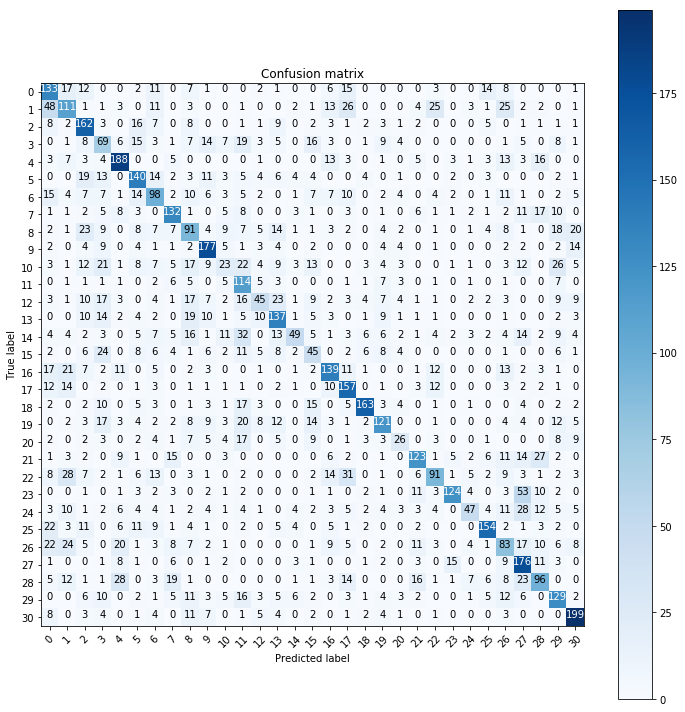

In [ ]:
pred = inter.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, range(0,31))
plt.show()

# All Data

In [ ]:
all_df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        fld=1, 
                        blocksize=blocksize, 
                        overlap=overlap)

In [ ]:
all_a_data = all_df[all_df['l_target'] == 0]
all_i_data = all_df[all_df['l_target'] == 1]

In [ ]:
X = all_a_data.drop(['l_target', 'h_target'], axis=1)
y = all_a_data['h_target']

In [ ]:
pred = anim.predict(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, range(0,19))
plt.show()

0.1900986269580352
Confusion matrix, without normalization
[[ 68  12  14   6  15  18   3   1   3   0   0   0   3  31   0   6  14  28
    6]
 [  8  29   4  15   8  12   0   1  10   6   5   1  13  23   2   9   2   9
    2]
 [  0   1  99  36  15   7   5  16  20   4   1   5   6   8  21  31   3  20
   14]
 [  6   2  43  40  12  16   0  16  15   4  21   7  10  43   2  21   3   9
   15]
 [  2   0  28  11  75  57  16   2  23  17   1   0  10   3   5  26   3  28
    5]
 [  2   4  29  17   6  23   2  21  18  22   7  31  21  17   4  33   0   5
   17]
 [  5   2  63   7  13  22  22  52   9   9   3  15   4  10   6  32   6  24
    8]
 [  0   6  53  14   2   8   1  55  24  18  15   9   8   6   6  38   3   4
   15]
 [  1   5  39  45  21  21   2  10  46  24   6   7  15  11   1  28   1  14
   12]
 [ 12  19  29   8  15  50   1   3  19  14   0   4  32  23   7  38   4  12
    6]
 [  0   2  16   5   1  11   1  81  13  18  69  15   0   8  25  20   0   8
   19]
 [  1   3  30  12   7   7   3  54  11  12  19  45 

In [ ]:
X = all_i_data.drop(['l_target', 'h_target'], axis=1)
y = all_i_data['h_target']

In [ ]:
pred = inter.predict(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, range(0,31))
plt.show()